[*********************100%%**********************]  1 of 1 completed


Running LongOnlyMACD Strategy:
----------------------------------------------------------------------
LongOnlyMACD(symbol = BBCA.JK, fast = 12, slow = 26, signal = 9) strategy backtest.
----------------------------------------------------------------------
2020-02-18 00:00:00 |  Buying 0.1494 BBCA.JK for 6695.0
2020-02-19 00:00:00 |  Selling 0.1494 BBCA.JK for 6695.0
2020-03-30 00:00:00 |  Buying 0.182 BBCA.JK for 5495.0
2020-04-22 00:00:00 |  Selling 0.182 BBCA.JK for 5145.0
2020-05-04 00:00:00 |  Buying 0.1794 BBCA.JK for 5220.0
2020-05-15 00:00:00 |  Selling 0.1794 BBCA.JK for 4785.0
2020-05-28 00:00:00 |  Buying 0.1621 BBCA.JK for 5295.0
2020-06-19 00:00:00 |  Selling 0.1621 BBCA.JK for 5575.0
2020-07-02 00:00:00 |  Buying 0.1539 BBCA.JK for 5870.0
2020-07-21 00:00:00 |  Selling 0.1539 BBCA.JK for 6200.0
2020-08-18 00:00:00 |  Buying 0.1501 BBCA.JK for 6360.0
2020-08-24 00:00:00 |  Selling 0.1501 BBCA.JK for 6315.0
2020-08-27 00:00:00 |  Buying 0.1436 BBCA.JK for 6600.0
2020-08-31


************************************************************
                    BACKTESTING RESULTS                     
************************************************************

                          Overview                          
------------------------------------------------------------
Total Duration                          4 years and 24 weeks
Start Date                               2020-02-18 00:00:00
End Date                                 2024-08-04 00:00:00
Trading Costs [%]                                        0.0
Exposure Time [%]                                      46.79
Leverage [x]                                               1
Equity - Initial [USDT]                                 1000
Equity - Final [USDT]                                 957.01
Equity - Peak [USDT]                                 1127.59
------------------------------------------------------------

                          Returns                           
---------------------

C:\Users\Intel X Nvidia RTX\anaconda3\envs\py10\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



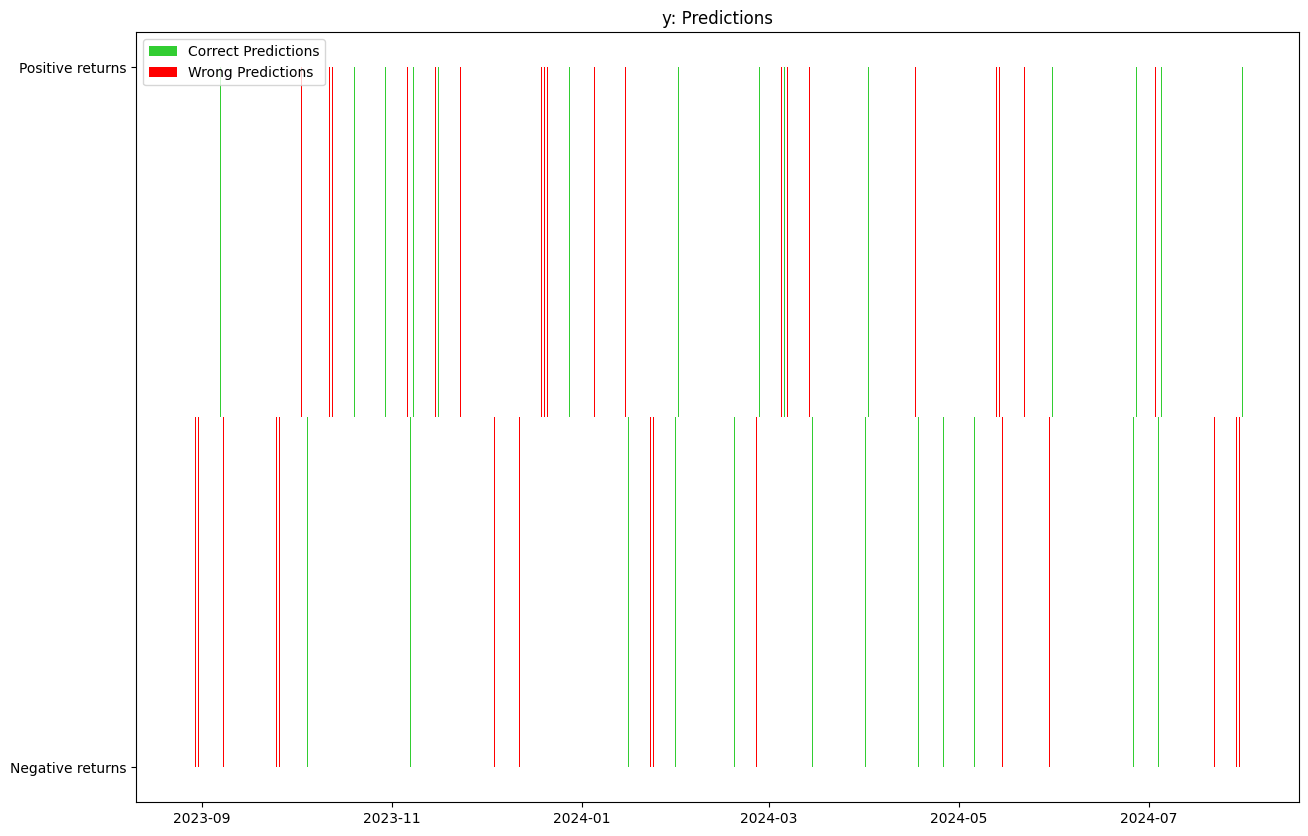

	saving model...


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Intel X Nvidia RTX\\ZenTraderML\\ZenTraderML-\\stratestic\\strategies\\machine_learning\\models\\random_forest-classification-max_depth=5,n_estimators=10,max_features=1,random_state=42.pkl'

In [18]:
import pandas as pd
import numpy as np
import yfinance as yf
from stratestic.backtesting import IterativeBacktester
from stratestic.strategies import MovingAverageConvergenceDivergence
from stratestic.strategies.trend.momentum import Momentum
from stratestic.strategies.machine_learning import MachineLearning
from collections import OrderedDict

def download_data(ticker, start_date):
    """Download stock data using yfinance."""
    try:
        data = yf.download(ticker, start=start_date, interval='1d')
        if data.empty:
            return None
        return data
    except Exception as e:
        print(f"Error downloading data for {ticker}: {e}")
        return None

class LongOnlyMACD(MovingAverageConvergenceDivergence):
    """Long-only MACD strategy."""
    def __init__(self, window_slow, window_fast, window_sign, data=None, symbol=''):
        super().__init__(window_slow, window_fast, window_sign, data)
        self.symbol = symbol

    def get_signal(self, row=None):
        if row is None:
            row = self.data.iloc[-1]
        return 1 if row["macd_diff"] > 0 else 0

class LongOnlyMomentum(Momentum):
    """Long-only Momentum strategy."""
    def __init__(self, window, data=None, symbol=''):
        super().__init__(window, data)
        self.symbol = symbol

    def get_signal(self, row=None):
        """Override to ensure only long signals are generated."""
        if row is None:
            row = self.data.iloc[-1]
        return 1 if row["rolling_returns"] > 0 else 0

class LongOnlyMachineLearning(MachineLearning):
    """Long-only Machine Learning strategy."""
    def __init__(self, estimator, lag_features, nr_lags, test_size, verbose, data=None, symbol=''):
        super().__init__(estimator=estimator, lag_features=lag_features, nr_lags=nr_lags, test_size=test_size, verbose=verbose, data=data)
        self.symbol = symbol

    def get_signal(self, row=None):
        """Override to ensure only long signals are generated."""
        if row is None:
            row = self.data.iloc[-1]
        prediction = self.model.predict([row])[0]
        return 1 if prediction > 0 else 0  # Assuming positive prediction indicates long signal

def run_backtest(strategy_class, data, symbol, **strategy_kwargs):
    """Run backtest for a given strategy."""
    strategy = strategy_class(**strategy_kwargs, data=data, symbol=symbol)
    ite = IterativeBacktester(strategy, symbol=symbol)
    ite.load_data(data)
    ite.run()

def prepare_data(ticker, start_date):
    """Prepare and clean the data for backtesting."""
    data = download_data(ticker, start_date)
    if data is not None:
        # Ensure the data has the necessary columns and rename if necessary
        required_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
        data.columns = [col.lower() for col in data.columns]  # Convert columns to lowercase for consistency
        if all(col in data.columns for col in ['open', 'high', 'low', 'close', 'volume']):
            return data
        else:
            print(f"Data is missing required columns. Found columns: {data.columns}")
            return None
    else:
        print("Failed to download data.")
        return None

def main():
    # Specify the ticker and start date
    ticker = "BBCA.JK"
    start_date = "2020-01-01"

    # Prepare data
    real_data = prepare_data(ticker, start_date)

    if real_data is not None:
        # Define the strategies to test
        strategies = [
            {
                "name": "LongOnlyMACD",
                "class": LongOnlyMACD,
                "params": {"window_slow": 26, "window_fast": 12, "window_sign": 9}
            },
            {
                "name": "LongOnlyMomentum",
                "class": LongOnlyMomentum,
                "params": {"window": 20}
            },
            {
                "name": "LongOnlyMachineLearning",
                "class": LongOnlyMachineLearning,
                "params": {
                    "estimator": "Random Forest",
                    "lag_features": ["returns"],
                    "nr_lags": 5,
                    "test_size": 0.2,
                    "verbose": True
                }
            }
        ]

        # Run each strategy
        for strategy_config in strategies:
            print(f"\nRunning {strategy_config['name']} Strategy:")
            run_backtest(strategy_config["class"], real_data, symbol=ticker, **strategy_config["params"])

if __name__ == "__main__":
    main()
